In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# K-modes
import kmodes

# 나무
from sklearn.tree import export_graphviz
import graphviz

# 데이터 분할
from sklearn.model_selection import train_test_split

# 예측 모형: Logistic regression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as gbC
from sklearn.ensemble import GradientBoostingClassifier as GBC

from sklearn.model_selection import GridSearchCV

# 평가 함수
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, f1_score


# https://pypi.org/project/kmodes/
from kmodes.kmodes import KModes

%matplotlib inline
matplotlib.rc('font', family = 'NanumBarunGothic')

path = '/home/pirl/BDAI-정덕성/Group/Python/'
list_files = ['user.csv', 'address.csv', 'contract.csv']

In [2]:
df = pd.read_csv(path + 'merged_final.csv', engine='python', encoding = 'euc-kr')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49645 entries, 0 to 49644
Data columns (total 23 columns):
gender              49645 non-null object
customerType        49645 non-null object
age                 49645 non-null object
marital             49645 non-null object
residence           49645 non-null object
channel             49645 non-null object
credit              49645 non-null object
payment             49645 non-null object
paymentCO           49645 non-null object
province            49645 non-null object
provinceIS          49645 non-null object
cityGrade           49645 non-null object
channelType         49645 non-null object
contractExtended    49645 non-null object
contractType        49645 non-null object
contractType_1      49645 non-null object
contractType_2      49645 non-null object
cityGradeIS         49645 non-null object
Termination_str     49645 non-null object
maxDay_str          49645 non-null object
maxGift_str         49645 non-null object
Terminati

## X & Y 분리: cityGradeIS 기준

In [4]:
df.head()

,gender,customerType,age,marital,residence,channel,credit,payment,paymentCO,province,...,contractExtended,contractType,contractType_1,contractType_2,cityGradeIS,Termination_str,maxDay_str,maxGift_str,Termination_rate,overDue_str
0,FEMALE,PERSONAL,50대,SINGLE,OFFICETEL,서비스 방문,MIDDLE,CARD,현대카드,경기도,...,연장,MMQ,M,M,2급지,중도 해약 X,목요일,지급 X,A,0일
1,FEMALE,PERSONAL,20대,MARRIED,OFFICETEL,렌탈재계약,MIDDLE,CMS,국민은행,서울시,...,연장,EIQ,E,I,1급지,중도 해약 X,토요일,지급 O,A,0일
2,FEMALE,PERSONAL,30대,MARRIED,OFFICETEL,렌탈총판,HIGH,CMS,기업은행,충청도,...,신규,HIQ,H,I,1급지,중도 해약 X,화요일,지급 O,B,0일
3,MALE,PERSONAL,20대,MARRIED,ETC.,하이마트,MIDDLE,CMS,국민은행,서울시,...,신규,MIQ,M,I,1급지,중도 해약 X,토요일,지급 O,B,0일
4,MALE,PERSONAL,30대,SINGLE,ETC.,하이마트,MIDDLE,CMS,기업은행,서울시,...,신규,MMQ,M,M,2급지,중도 해약 X,목요일,지급 O,B,0일


In [5]:
df_tree = df.query('Termination_str == "중도 해약 X"')
df_tree['Termination_str'].unique()

array(['중도 해약 X'], dtype=object)

# 등급 3종 추천 모형

In [6]:
df_tree_short = df_tree.drop(['channel', 'channelType',  # channelType 사용
                   'credit', 'payment', 'paymentCO', # 경향성 없음
                   'province', 'provinceIS',
                   'cityGrade', # 실거주지 정보 제외
                   'contractExtended', # 목표변수 파생변수 제외
                   'contractType', 'contractType_2', # 6개 범주 사용
                   'Termination_str', 
                   'maxDay_str', 'maxGift_str', 'Termination_rate', 'overDue_str'],
                       axis=1) # 경향성 없음             
                                  
# X, Y 분리 & Dummy 변수
df_tree_y = df_tree[['contractType_1']]

In [7]:
df_tree_y['contractType_1'].unique()

array(['M', 'E', 'H'], dtype=object)

In [8]:
df_tree_s = pd.get_dummies(df_tree_short.drop('contractType_1', axis=1), drop_first = True)
df_tree_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47566 entries, 0 to 49644
Data columns (total 15 columns):
gender_MALE              47566 non-null uint8
customerType_PERSONAL    47566 non-null uint8
age_30대                  47566 non-null uint8
age_40대                  47566 non-null uint8
age_50대                  47566 non-null uint8
age_60대 이상               47566 non-null uint8
marital_SINGLE           47566 non-null uint8
residence_ETC.           47566 non-null uint8
residence_HOUSE          47566 non-null uint8
residence_OFFICETEL      47566 non-null uint8
cityGradeIS_2급지          47566 non-null uint8
cityGradeIS_3급지          47566 non-null uint8
cityGradeIS_4급지          47566 non-null uint8
cityGradeIS_5급지          47566 non-null uint8
cityGradeIS_6급지          47566 non-null uint8
dtypes: uint8(15)
memory usage: 1.0 MB


In [9]:
# 나무 데이터
df_train_s, df_test_s, df_train_y, df_test_y = train_test_split(df_tree_s, df_tree_y, test_size = 0.3)

print('train data X size:{}'.format(df_train_s.shape))
print('train data Y size:{}'.format(df_train_y.shape))
print('test data X size:{}'.format(df_test_s.shape))
print('test data Y size:{}'.format(df_test_y.shape))

train data X size:(33296, 15)
train data Y size:(33296, 1)
test data X size:(14270, 15)
test data Y size:(14270, 1)


In [10]:
gb_default = GBC()
gb_default.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [16]:
y_train_pred = gb_default.predict(df_train_s)
y_test_pred = gb_default.predict(df_test_s)

# # AUC
# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_train_y, y_pred)
# roc_auc_train = auc(false_positive_rate, true_positive_rate)

# false_positive_rate, true_positive_rate, thresholds = roc_curve(df_test_y, y_pred)
# roc_auc_test = auc(false_positive_rate, true_positive_rate)

# f1 score
f1_train = f1_score(df_train_y, y_train_pred, average='micro')
f1_test = f1_score(df_test_y, y_test_pred, average='micro')


# print('Accuracy on Training: {0:.3f}\n'.format(gb_default.score(df_train_s, df_train_y)))
# print('Accuracy on Test: {0:.3f}\n'.format(gb_default.score(df_test_s, df_test_y)))

# # print('AUC on Training: {0:.3f}\n'.format(roc_auc_train))
# # print('AUC on Test: {0:.3f}\n'.format(roc_auc_test))
print('F1 on Training: {0:.3f}\n'.format(f1_train))
print('F1 on Test: {0:.3f}\n'.format(f1_test))

F1 on Training: 0.849

F1 on Test: 0.845



In [11]:
params = {'learning_rate': None,
          'max_depth': None,
          'n_estimators': None,
          'max_leaf_nodes': None,
          'min_samples_leaf': None,
          'min_samples_split': None,
          'max_features': None}

### 학습률

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d

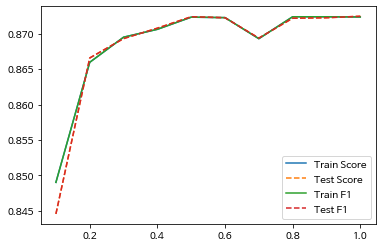

In [14]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# lrate
para_lrate = [lrate*0.1 for lrate in range(1, 11)]


for v_lrate in para_lrate:
    gb = GBC(learning_rate = v_lrate)
    gb.fit(df_train_s, df_train_y)
    y_train_pred = gb.predict(df_train_s)
    y_test_pred = gb.predict(df_test_s)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_lrate = pd.DataFrame({'LRate': para_lrate,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_lrate, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_lrate, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_lrate, train_f1, linestyle='-', label="Train F1")
plt.plot(para_lrate, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [17]:
df_score_lrate.sort_values('TestF1', ascending = False)

,LRate,TrainScore,TestScore,TrainF1,TestF1
9,1.0,0.872357,0.872460,0.872357,0.872460
4,0.5,0.872327,0.872390,0.872327,0.872390
5,0.6,0.872267,0.872249,0.872267,0.872249
8,0.9,0.872387,0.872249,0.872387,0.872249
7,0.8,0.872387,0.872179,0.872387,0.872179
3,0.4,0.870615,0.870778,0.870615,0.870778
6,0.7,0.869294,0.869376,0.869294,0.869376
2,0.3,0.869504,0.869306,0.869504,0.869306
1,0.2,0.865960,0.866573,0.865960,0.866573
0,0.1,0.849021,0.844569,0.849021,0.844569


In [26]:
params['learning_rate'] = 0.5

### 숲의 나무 개수

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d

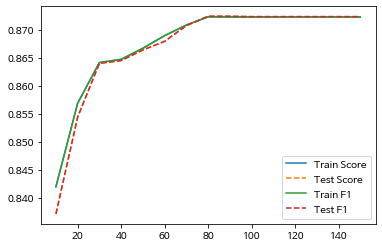

In [27]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# ntree
para_ntree = [10*ntree for ntree in range(1, 16)]


for v_ntree in para_ntree:
    gb = GBC(learning_rate = params['learning_rate'],
             n_estimators = v_ntree)
    gb.fit(df_train_s, df_train_y)
    y_train_pred = gb.predict(df_train_s)
    y_test_pred = gb.predict(df_test_s)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_ntree = pd.DataFrame({'N_Tree': para_ntree,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_ntree, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_ntree, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_ntree, train_f1, linestyle='-', label="Train F1")
plt.plot(para_ntree, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [28]:
df_score_ntree.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
7,80,0.872357,0.872460,0.872357,0.872460
8,90,0.872327,0.872460,0.872327,0.872460
9,100,0.872327,0.872390,0.872327,0.872390
10,110,0.872327,0.872390,0.872327,0.872390
11,120,0.872327,0.872390,0.872327,0.872390
12,130,0.872327,0.872390,0.872327,0.872390
13,140,0.872327,0.872390,0.872327,0.872390
14,150,0.872327,0.872390,0.872327,0.872390
6,70,0.870885,0.870778,0.870885,0.870778
5,60,0.868993,0.867975,0.868993,0.867975


In [30]:
params['n_estimators'] = 80

### 나무의 최대 깊이

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d

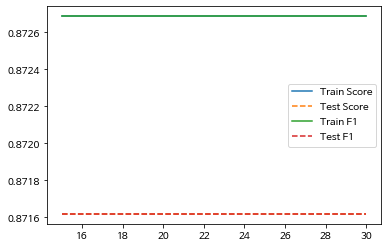

In [31]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# depth
para_depth = [depth for depth in range(15, 31)]


for v_depth in para_depth:
    gb = GBC(learning_rate = params['learning_rate'],
             n_estimators = params['n_estimators'],
             max_depth = v_depth)
    gb.fit(df_train_s, df_train_y)
    y_train_pred = gb.predict(df_train_s)
    y_test_pred = gb.predict(df_test_s)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_depth = pd.DataFrame({'N_Tree': para_depth,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_depth, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_depth, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_depth, train_f1, linestyle='-', label="Train F1")
plt.plot(para_depth, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [138]:
df_score_depth.sort_values('TestF1', ascending = False)

,N_Tree,TrainScore,TestScore,TrainF1,TestF1
3,18,0.870915,0.876594,0.870915,0.876594
4,19,0.870915,0.876594,0.870915,0.876594
12,27,0.870915,0.876594,0.870915,0.876594
1,16,0.870915,0.876524,0.870915,0.876524
5,20,0.870915,0.876524,0.870915,0.876524
10,25,0.870915,0.876524,0.870915,0.876524
11,26,0.870915,0.876524,0.870915,0.876524
13,28,0.870915,0.876524,0.870915,0.876524
0,15,0.870915,0.876454,0.870915,0.876454
6,21,0.870915,0.876454,0.870915,0.876454


In [139]:
params['max_depth'] = 18

### 최종 노드의 최소 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys

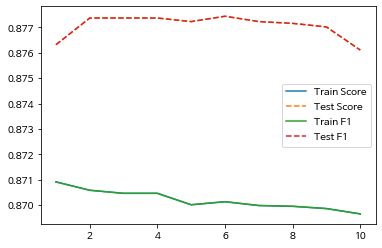

In [140]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# leaf
para_leaf = [leaf for leaf in range(1, 11)]


for v_leaf in para_leaf:
    gb = gbC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = v_leaf)
    gb.fit(df_train_s, df_train_y)
    y_train_pred = gb.predict(df_train_s)
    y_test_pred = gb.predict(df_test_s)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_leaf = pd.DataFrame({'Leaf': para_leaf,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_leaf, train_f1, linestyle='-', label="Train F1")
plt.plot(para_leaf, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [141]:
df_score_leaf.sort_values('TestF1', ascending = False)

,Leaf,TrainScore,TestScore,TrainF1,TestF1
5,6,0.870135,0.877435,0.870135,0.877435
1,2,0.870585,0.877365,0.870585,0.877365
2,3,0.870465,0.877365,0.870465,0.877365
3,4,0.870465,0.877365,0.870465,0.877365
4,5,0.870014,0.877225,0.870014,0.877225
6,7,0.869984,0.877225,0.869984,0.877225
7,8,0.869954,0.877155,0.869954,0.877155
8,9,0.869864,0.877015,0.869864,0.877015
0,1,0.870915,0.876314,0.870915,0.876314
9,10,0.869654,0.876104,0.869654,0.876104


In [142]:
params['min_samples_leaf'] = 6

### 분리 노드의 최소 크기

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/home/pi

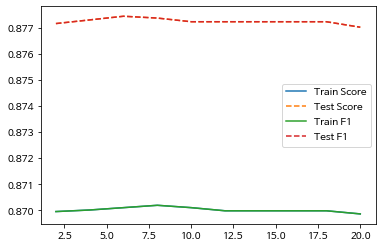

In [143]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# split
para_split = [split*2 for split in range(1, 11)]


for v_split in para_split:
    gb = gbC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = v_split)
    gb.fit(df_train_s, df_train_y)
    y_train_pred = gb.predict(df_train_s)
    y_test_pred = gb.predict(df_test_s)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_split = pd.DataFrame({'split': para_split,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_split, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_split, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_split, train_f1, linestyle='-', label="Train F1")
plt.plot(para_split, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [144]:
df_score_split.sort_values('TestF1', ascending = False)

,split,TrainScore,TestScore,TrainF1,TestF1
2,6,0.870105,0.877435,0.870105,0.877435
3,8,0.870195,0.877365,0.870195,0.877365
1,4,0.870014,0.877295,0.870014,0.877295
4,10,0.870105,0.877225,0.870105,0.877225
5,12,0.869984,0.877225,0.869984,0.877225
6,14,0.869984,0.877225,0.869984,0.877225
7,16,0.869984,0.877225,0.869984,0.877225
8,18,0.869984,0.877225,0.869984,0.877225
0,2,0.869954,0.877155,0.869954,0.877155
9,20,0.869864,0.877015,0.869864,0.877015


In [145]:
params['min_samples_split'] = 6

### 최대 사용 변수

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

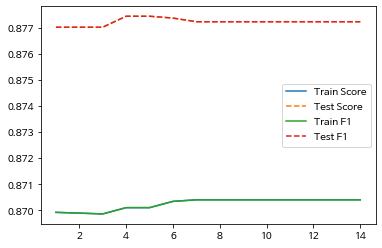

In [146]:
# Train/Test Score 저장할 list
train_accuracy = []; test_accuracy = []; train_f1 = []; test_f1 = []

# feature
para_feature = [feature for feature in range(1, len(df_train_s.columns))]


for v_feature in para_feature:
    gb = gbC(n_estimators = params['n_estimators'],
             max_depth = params['max_depth'],
             min_samples_leaf = params['min_samples_leaf'],
             min_samples_split = params['min_samples_split'],
             max_features = v_feature)
    gb.fit(df_train_s, df_train_y)
    y_train_pred = gb.predict(df_train_s)
    y_test_pred = gb.predict(df_test_s)
    train_accuracy.append(gb.score(df_train_s, df_train_y))
    test_accuracy.append(gb.score(df_test_s, df_test_y))
    train_f1.append(f1_score(df_train_y, y_train_pred, average='micro'))
    test_f1.append(f1_score(df_test_y, y_test_pred, average='micro'))
    
    
df_score_feature = pd.DataFrame({'feature': para_feature,
                             'TrainScore': train_accuracy,
                             'TestScore': test_accuracy,
                             'TrainF1': train_f1,
                             'TestF1': test_f1})

plt.plot(para_feature, train_accuracy, linestyle='-', label="Train Score")
plt.plot(para_feature, test_accuracy, linestyle='--', label="Test Score")
plt.plot(para_feature, train_f1, linestyle='-', label="Train F1")
plt.plot(para_feature, test_f1, linestyle='--', label="Test F1")
plt.legend()

In [147]:
df_score_feature.sort_values('TestF1', ascending = False)

,feature,TrainScore,TestScore,TrainF1,TestF1
3,4,0.870105,0.877435,0.870105,0.877435
4,5,0.870105,0.877435,0.870105,0.877435
5,6,0.870345,0.877365,0.870345,0.877365
6,7,0.870405,0.877225,0.870405,0.877225
7,8,0.870405,0.877225,0.870405,0.877225
8,9,0.870405,0.877225,0.870405,0.877225
9,10,0.870405,0.877225,0.870405,0.877225
10,11,0.870405,0.877225,0.870405,0.877225
11,12,0.870405,0.877225,0.870405,0.877225
12,13,0.870405,0.877225,0.870405,0.877225


In [148]:
params['max_features'] = 4

# 최종 모형

In [22]:
gb_final = GBC(
#     n_estimators = params['n_estimators'],
#     max_depth = params['max_depth'],
#              min_samples_leaf = params['min_samples_leaf'],
#              min_samples_split = params['min_samples_split'],
#              max_features = params['max_features']
                )
gb_final.fit(df_train_s, df_train_y)

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [23]:
y_pred = gb_final.predict(df_test_s)

# f1 score
f1Score = f1_score(df_test_y, y_pred, average = 'micro')

print('F1: {0:.3f}\n'.format(f1Score))
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test_y, y_pred)))
print('Confusion Mat:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

F1: 0.845

Accuracy: 0.845

Confusion Mat:
[[2942   37  814]
 [ 273 1795  613]
 [ 347  134 7315]]


In [24]:
df_importance = pd.DataFrame()
v_feature_name = df_train_s.columns
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_ # TREECLASS.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
0,gender_MALE,0.152
3,age_40대,0.149
1,customerType_PERSONAL,0.123
10,cityGradeIS_2급지,0.116
6,marital_SINGLE,0.102
2,age_30대,0.099
4,age_50대,0.047
13,cityGradeIS_5급지,0.047
12,cityGradeIS_4급지,0.041
8,residence_HOUSE,0.039


Text(0, 0.5, '변수')

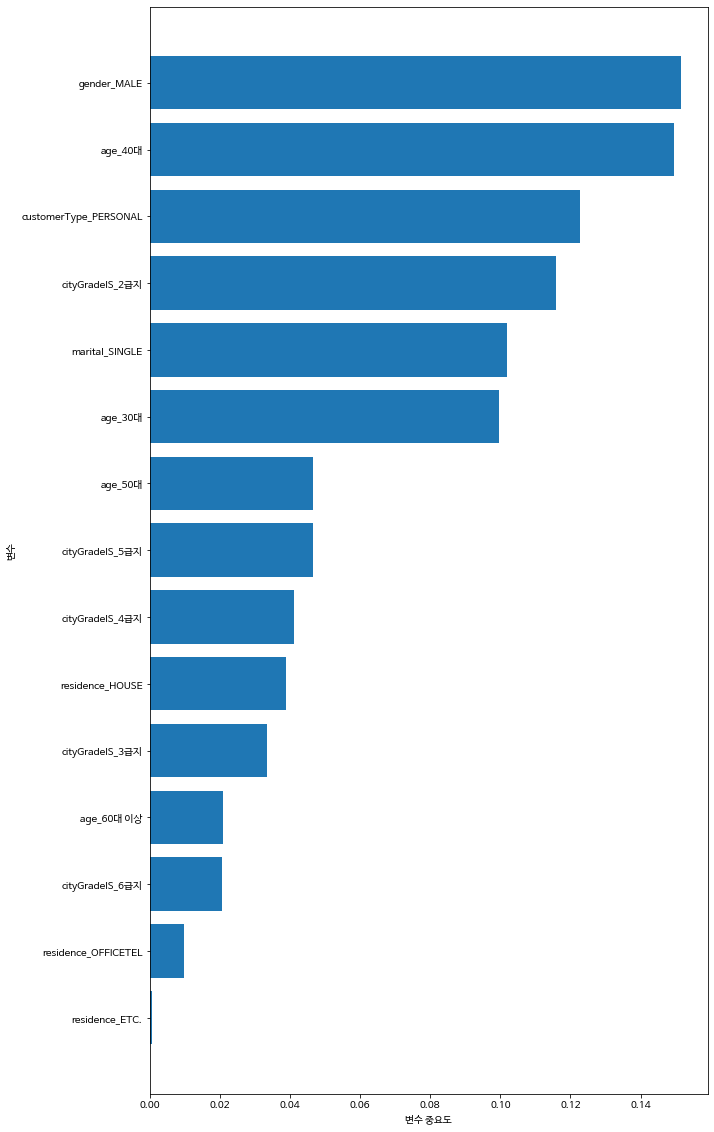

In [25]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')